**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: December 29, 2023 23:59 (GMT+3)</center></h4>

## **CIFAR-100 Inpainting**

### **Homework Description**

In this assignment, we are asked to design and train a Convolutional Neural Network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. We will be applying this task on the preprocessed CIFAR-100 dataset, which is created for this homework by processing the original [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 28x28 pixel resolution. You can see a subset of the dataset below.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)



### **Importing the Libraries**

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-100 dataset is downloadable from [this link](https://drive.google.com/file/d/1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
import gdown # Library to download files from Google Drive
!gdown 1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL # Google Drive ID of the zip file to be downloaded
!unzip -oq cifar100.zip # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL
To: /content/cifar100.zip
100% 64.1M/64.1M [00:00<00:00, 85.6MB/s]


### **Implementing a Custom Dataset [25 Points]**

In this part, we are going to implement a custom PyTorch dataset class that reads CIFAR-100 images from a dataset split folder. There are two split folders called train and test in the dataset. We will follow these steps for this part:
* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)


In [6]:
class CifarDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.images = []
        self.labels = []
        self.load_images()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, data_id):
        return self.labels[data_id], self.images[data_id]

    def load_images(self):
        file_list = self.file_list
        for file_id, file_name in enumerate(file_list):
            class_path = os.path.join(self.root_dir, file_name)
            image_list = os.listdir(class_path)
            image_paths = [os.path.join(class_path, image_file) for image_file in image_list]
            for image_path in image_paths:
                with Image.open(image_path) as image:
                    image_tensor = self.transform(image)
                    self.images.append(image_tensor)
                    self.labels.append(file_id)



In [7]:
train_dataset = CifarDataset("/content/cifar100/train")
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True )

test_dataset = CifarDataset("/content/cifar100/test")
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 512, shuffle = False)

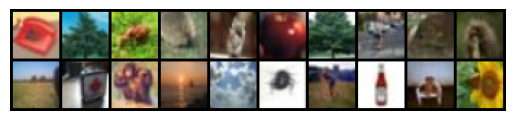

In [8]:
_, images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, we are going to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers will be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)


In [9]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        ### Encoder Network
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 4, padding = 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 4, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, padding = 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        ### Decoder Network
        self.transpose_block_1 = nn.Sequential(
            nn.ConvTranspose2d (in_channels = 64, out_channels = 32, kernel_size = 4, stride = 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
        )
        self.transpose_block_2 = nn.Sequential(
            nn.ConvTranspose2d (in_channels = 32, out_channels = 16, kernel_size = 4, stride = 2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
        )
        self.transpose_block_3 = nn.Sequential(
            nn.ConvTranspose2d (in_channels = 16, out_channels = 3, kernel_size = 6, stride = 2),
            nn.BatchNorm2d(3),
            nn.Tanh() # Note that we use Tanh activation function in the last layer, as indicated in the Markdown
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.transpose_block_1(x)
        x = self.transpose_block_2(x)
        x = self.transpose_block_3(x)
        return x

### **Implementing the Training Loop [15 Points]**

We will define our training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. T

To be able for our model to learn inpainting, we will mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)


In [10]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    iter_losses = []
    epoch_losses = []
    num_batches = len(train_dataloader)

    for epoch in tqdm(range(num_epochs), desc = "Training Progress", total = num_epochs, position = 0, leave = True):
        iter_loss = 0.0
        for img_class, img_tensor in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):

            # move image and class label to cuda
            if torch.cuda.is_available():
                img_tensor = img_tensor.cuda()
                img_class = img_class.cuda()

            # mask the image
            img_tensor_masked = torch.clone(img_tensor)
            img_tensor_masked[:,:,:, 16:32] = -1

            # prevent accumulation of gradients
            optimizer.zero_grad()

            # forward pass with the masked image
            output = model(img_tensor_masked)

            # calculate and record the loss
            loss = loss_func(output, img_tensor)
            loss.backward()
            iter_losses.append(loss.item())
            iter_loss += loss.item()

            # update the weights and biases
            optimizer.step()

        epoch_loss = iter_loss / num_batches
        epoch_losses.append(epoch_loss)
        print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")
    return iter_losses, epoch_losses

### **Implementing the Evaluation Function [15 Points]**

Now we implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [11]:
def evaluate_model(model, test_dataloader):

    # set the model to evaluation mode for inference
    model.eval()

    # loss function and total MSE initialization
    loss_func = nn.MSELoss()
    MSE = 0

    # stop computing gradients
    with torch.no_grad():
        for img_class, img_tensor in tqdm(test_dataloader, desc = "Evaluation Progress"):
            if torch.cuda.is_available():
                img_tensor = img_tensor.cuda()

            # use the trained model to predict the test data
            outputs = model(img_tensor)

            # calculate and record the loss
            MSE += loss_func(outputs, img_tensor)
        return MSE


### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later.

In [12]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    _, images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

In [13]:
seed_everything(464)
model = CifarAutoencoder()
loss_func = nn.MSELoss()
if torch.cuda.is_available():
    model.cuda()
lr_ = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr_)
num_epochs = 50
iter_losses, epoch_losses = train_model(model, train_dataloader, optimizer, loss_func, num_epochs)

Training Progress:   2%|▏         | 1/50 [00:06<05:07,  6.28s/it]


Epoch 1 Loss: 0.1465586193020234


Training Progress:   4%|▍         | 2/50 [00:10<04:06,  5.15s/it]


Epoch 2 Loss: 0.09265022798229361


Training Progress:   6%|▌         | 3/50 [00:14<03:43,  4.76s/it]


Epoch 3 Loss: 0.08503798944184847


Training Progress:   8%|▊         | 4/50 [00:19<03:40,  4.79s/it]


Epoch 4 Loss: 0.08158095222909736


Training Progress:  10%|█         | 5/50 [00:24<03:27,  4.62s/it]


Epoch 5 Loss: 0.07873326854403977


Training Progress:  12%|█▏        | 6/50 [00:28<03:18,  4.51s/it]


Epoch 6 Loss: 0.07589626613804294


Training Progress:  14%|█▍        | 7/50 [00:33<03:19,  4.64s/it]


Epoch 7 Loss: 0.07397924173061195


Training Progress:  16%|█▌        | 8/50 [00:37<03:10,  4.53s/it]


Epoch 8 Loss: 0.07272940200022267


Training Progress:  18%|█▊        | 9/50 [00:41<03:02,  4.46s/it]


Epoch 9 Loss: 0.07199260065108157


Training Progress:  20%|██        | 10/50 [00:46<03:03,  4.59s/it]


Epoch 10 Loss: 0.07095934395842693


Training Progress:  22%|██▏       | 11/50 [00:51<02:55,  4.51s/it]


Epoch 11 Loss: 0.0701931010017081


Training Progress:  24%|██▍       | 12/50 [00:55<02:50,  4.49s/it]


Epoch 12 Loss: 0.06977949553000196


Training Progress:  26%|██▌       | 13/50 [01:00<02:48,  4.56s/it]


Epoch 13 Loss: 0.06917840105664852


Training Progress:  28%|██▊       | 14/50 [01:04<02:41,  4.48s/it]


Epoch 14 Loss: 0.06867455974068788


Training Progress:  30%|███       | 15/50 [01:09<02:41,  4.60s/it]


Epoch 15 Loss: 0.06844195940762834


Training Progress:  32%|███▏      | 16/50 [01:13<02:35,  4.58s/it]


Epoch 16 Loss: 0.06809522058157359


Training Progress:  34%|███▍      | 17/50 [01:18<02:28,  4.50s/it]


Epoch 17 Loss: 0.06758124175984079


Training Progress:  36%|███▌      | 18/50 [01:22<02:25,  4.55s/it]


Epoch 18 Loss: 0.0676218672272037


Training Progress:  38%|███▊      | 19/50 [01:27<02:19,  4.51s/it]


Epoch 19 Loss: 0.06715101147037181


Training Progress:  40%|████      | 20/50 [01:31<02:13,  4.46s/it]


Epoch 20 Loss: 0.0669723897029067


Training Progress:  42%|████▏     | 21/50 [01:36<02:12,  4.57s/it]


Epoch 21 Loss: 0.06667504651600595


Training Progress:  44%|████▍     | 22/50 [01:40<02:05,  4.50s/it]


Epoch 22 Loss: 0.06637461052831177


Training Progress:  46%|████▌     | 23/50 [01:45<01:59,  4.44s/it]


Epoch 23 Loss: 0.06602841687133855


Training Progress:  48%|████▊     | 24/50 [01:49<01:58,  4.56s/it]


Epoch 24 Loss: 0.06596905563283911


Training Progress:  50%|█████     | 25/50 [01:54<01:52,  4.48s/it]


Epoch 25 Loss: 0.06578413337526266


Training Progress:  52%|█████▏    | 26/50 [01:58<01:46,  4.43s/it]


Epoch 26 Loss: 0.06554451916852723


Training Progress:  54%|█████▍    | 27/50 [02:03<01:45,  4.59s/it]


Epoch 27 Loss: 0.0653502124568919


Training Progress:  56%|█████▌    | 28/50 [02:07<01:38,  4.49s/it]


Epoch 28 Loss: 0.06518272184731101


Training Progress:  58%|█████▊    | 29/50 [02:12<01:33,  4.44s/it]


Epoch 29 Loss: 0.06499318960491958


Training Progress:  60%|██████    | 30/50 [02:16<01:31,  4.56s/it]


Epoch 30 Loss: 0.06479153301462036


Training Progress:  62%|██████▏   | 31/50 [02:21<01:25,  4.49s/it]


Epoch 31 Loss: 0.06441441614685765


Training Progress:  64%|██████▍   | 32/50 [02:25<01:20,  4.48s/it]


Epoch 32 Loss: 0.06431779320663808


Training Progress:  66%|██████▌   | 33/50 [02:30<01:17,  4.55s/it]


Epoch 33 Loss: 0.06421916487405215


Training Progress:  68%|██████▊   | 34/50 [02:34<01:11,  4.47s/it]


Epoch 34 Loss: 0.06415768457419427


Training Progress:  70%|███████   | 35/50 [02:39<01:07,  4.51s/it]


Epoch 35 Loss: 0.06401941082094942


Training Progress:  72%|███████▏  | 36/50 [02:43<01:03,  4.55s/it]


Epoch 36 Loss: 0.06393149181666886


Training Progress:  74%|███████▍  | 37/50 [02:48<00:58,  4.48s/it]


Epoch 37 Loss: 0.06364793211812406


Training Progress:  76%|███████▌  | 38/50 [02:53<00:54,  4.56s/it]


Epoch 38 Loss: 0.06367663699476157


Training Progress:  78%|███████▊  | 39/50 [02:57<00:49,  4.51s/it]


Epoch 39 Loss: 0.06357965302055754


Training Progress:  80%|████████  | 40/50 [03:01<00:44,  4.47s/it]


Epoch 40 Loss: 0.06341550214802061


Training Progress:  82%|████████▏ | 41/50 [03:06<00:41,  4.59s/it]


Epoch 41 Loss: 0.0633243415504694


Training Progress:  84%|████████▍ | 42/50 [03:11<00:36,  4.51s/it]


Epoch 42 Loss: 0.06322657174485571


Training Progress:  86%|████████▌ | 43/50 [03:15<00:31,  4.46s/it]


Epoch 43 Loss: 0.06328519521390691


Training Progress:  88%|████████▊ | 44/50 [03:20<00:27,  4.59s/it]


Epoch 44 Loss: 0.06297757185976524


Training Progress:  90%|█████████ | 45/50 [03:24<00:22,  4.52s/it]


Epoch 45 Loss: 0.06285709999215877


Training Progress:  92%|█████████▏| 46/50 [03:28<00:17,  4.47s/it]


Epoch 46 Loss: 0.06299516541973861


Training Progress:  94%|█████████▍| 47/50 [03:33<00:13,  4.60s/it]


Epoch 47 Loss: 0.06285550152821004


Training Progress:  96%|█████████▌| 48/50 [03:38<00:09,  4.51s/it]


Epoch 48 Loss: 0.06271300120922306


Training Progress:  98%|█████████▊| 49/50 [03:42<00:04,  4.47s/it]


Epoch 49 Loss: 0.06255427063883418


Training Progress: 100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


Epoch 50 Loss: 0.06262159698626117


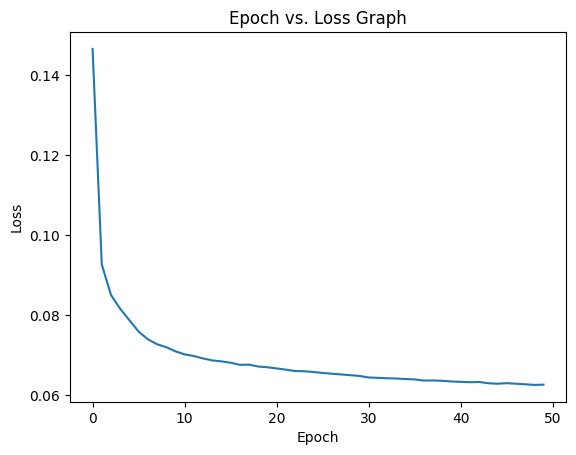

In [14]:
## Plot Epoch vs. Loss Graph
plt.plot(np.arange(num_epochs), epoch_losses)
plt.title("Epoch vs. Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

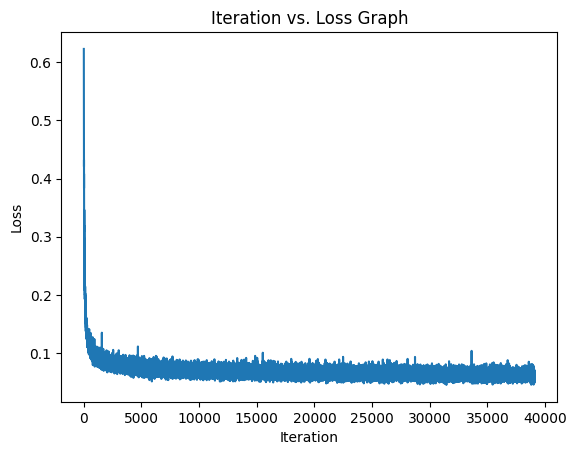

In [15]:
## Plot Iteration vs. Loss Graph

plt.plot(np.arange(len(iter_losses)), iter_losses)
plt.title("Iteration vs. Loss Graph")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

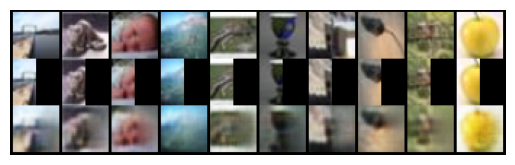

In [16]:
visualize_inpainting(model, test_dataset)

In [17]:
test_MSE = evaluate_model(model, test_dataloader)
print(f"\nMSE on test data: {test_MSE}")

Evaluation Progress: 100%|██████████| 20/20 [00:00<00:00, 84.25it/s]


MSE on test data: 5.4493842124938965
